### Importing Libraries

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader

import torchvision.transforms as transforms
import torchvision.transforms.functional as TF

import torch.optim as optim

import os

from PIL import Image, ImageOps

import random

#import any other library you need below this line

### Loading data

Upload the data in zip format to Colab. Then run the cell below.

In [4]:
!unzip data.zip

unzip:  cannot find either data.zip or data.zip.zip.


### Defining the Dataset Class

In [5]:
class Cell_data(Dataset):
  def __init__(self, data_dir, size, train = True, train_test_split = 0.8, augment_data = True):
    ##########################inputs##################################
    #data_dir(string) - directory of the data#########################
    #size(int) - size of the images you want to use###################
    #train(boolean) - train data or test data#########################
    #train_test_split(float) - the portion of the data for training###
    #augment_data(boolean) - use data augmentation or not#############
    super(Cell_data, self).__init__()
    self.size = size
    self.train = train
    self.augment_data = augment_data

    image_files = os.path.join(data_dir, 'scans')
    label_files = os.path.join(data_dir, 'labels')

    self.image_paths = sorted([os.path.join(image_files, f) for f in os.listdir(image_files)])
    self.label_paths = sorted([os.path.join(label_files, f) for f in os.listdir(label_files)])

    split_index = int(len(self.image_paths)*train_test_split)
    if self.train:
      self.image_paths = self.image_paths[:split_index]
      self.label_paths = self.label_paths[:split_index]
    else:
      self.image_paths = self.image_paths[split_index:]
      self.label_paths = self.label_paths[split_index:]
  
  def __getitem__(self, idx):
    image = Image.open(self.image_paths[idx]).resize((self.size, self.size))
    label = Image.open(self.label_paths[idx]).resize((self.size, self.size))

    if self.train:
      if self.augment_data:
        augment_mode = np.random.randint(0, 5)
        if augment_mode == 0:
          #todo
          #flip image vertically
          augmented_image = TF.vflip(image)
          augmented_label = TF.vflip(label)
        elif augment_mode == 1:
          #todo
          #flip image horizontally
          augmented_image = TF.hflip(image)
          augmented_label = TF.hflip(label)
        elif augment_mode == 2:
          # zoom image
          i, j, h, w = transforms.RandomResizedCrop.get_params(image, scale=(0.8, 1.0), ratio=(1.0, 1.0))
          augmented_image = TF.resized_crop(image, i, j, h, w, (self.size, self.size))
          augmented_label = TF.resized_crop(label, i, j, h, w, (self.size, self.size))

        elif augment_mode == 3:
          #rotate image
          angle = random.randint(-35, 35)
          augmented_image = TF.rotate(image, angle)
          augmented_label = TF.rotate(label, angle)

        elif augment_mode == 4:
          #gamma correction
          gamma = random.uniform(0.5, 2.0)
          augmented_image = TF.adjust_gamma(image, gamma)
          augmented_label = label
      else:
        augmented_image = image
        augmented_label = label
    else:
      augmented_image = image
      augmented_label = label

    img = transforms.ToTensor()(augmented_image)
    label = transforms.PILToTensor()(augmented_label)

    mean, std = img.mean([1, 2]), img.std([1, 2])

    img = transforms.Normalize(mean, std)(img)
    return img,label

  def __len__(self):
    return len(self.image_paths)

### Define the Model
1. Define the Convolution blocks
2. Define the down path
3. Define the up path
4. combine the down and up path to get the final model

In [6]:
class twoConvBlock(nn.Module):
  def __init__(self, input_channel, output_channel):
    super(twoConvBlock, self).__init__()
    #todo
    #initialize the block
    # first 3x3 convolution with ReLU
    self.conv1 = nn.Conv2d(input_channel, output_channel, kernel_size=3, padding=0)
    self.relu1 = nn.ReLU()

    # second 3x3 convolution with batch normalization and ReLU
    self.conv2 = nn.Conv2d(output_channel, output_channel, kernel_size=3, padding=0)
    self.bn2 = nn.BatchNorm2d(output_channel)
    self.relu2 = nn.ReLU()

  def forward(self, x):
    #todo
    #implement the forward path
    x = self.relu1(self.conv1(x))
    x = self.relu2(self.bn2(self.conv2(x)))

    return x

class downStep(nn.Module):
  def __init__(self, input_channel, output_channel):
      super(downStep, self).__init__()
      self.conv_block = twoConvBlock(input_channel, output_channel)
      self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2)

  def forward(self, x):
      x = self.conv_block(x)
      pooled_x = self.max_pool(x)
      return pooled_x, x 

class upStep(nn.Module):
  def __init__(self, input_channel, output_channel):
      super(upStep, self).__init__()
      self.up_conv = nn.ConvTranspose2d(input_channel, output_channel, kernel_size=2, stride=2)
      self.conv_block = twoConvBlock(input_channel, output_channel)
  
  def center_crop(self, tensor, target_size):
    _, _, h, w = tensor.size()
    target_h, target_w = target_size
    
    delta_h = h - target_h
    delta_w = w - target_w
    
    crop_h = delta_h // 2
    crop_w = delta_w // 2
    
    return tensor[:, :, crop_h:crop_h + target_h, crop_w:crop_w + target_w]

  def forward(self, x1, skip_connection):
    x1 = self.up_conv(x1)

    skip_connection_cropped = self.center_crop(skip_connection, x1.size()[2:])
    x = torch.cat([skip_connection_cropped, x1], dim=1)
    x = self.conv_block(x)
    return x


class UNet(nn.Module):
  def __init__(self):
    super(UNet, self).__init__()
    # contracting path
    self.down1 = downStep(1, 64)
    self.down2 = downStep(64, 128)
    self.down3 = downStep(128, 256)
    self.down4 = downStep(256, 512)

    # bottom layer of the unet without pooling
    self.bottom = twoConvBlock(512, 1024)

    # expansive Path
    self.up4 = upStep(1024, 512)
    self.up3 = upStep(512, 256)
    self.up2 = upStep(256, 128)
    self.up1 = upStep(128, 64)

    self.final_conv = nn.Conv2d(64, 2, kernel_size=1)


  def forward(self, x):
    # contracting
    pooled1, skip1 = self.down1(x)
    pooled2, skip2 = self.down2(pooled1)
    pooled3, skip3 = self.down3(pooled2)
    pooled4, skip4 = self.down4(pooled3)

    # bottom
    x = self.bottom(pooled4)

    # expansive path (use skip connections from the contracting path)
    x = self.up4(x, skip4)
    x = self.up3(x, skip3)
    x = self.up2(x, skip2)
    x = self.up1(x, skip1)

    # final 1x1 convo
    x = self.final_conv(x)
    return x


### Training

In [11]:
import wandb
wandb.login()

e:\dev\envs\anaconda3\envs\CMPT742-env\Lib\site-packages\pydantic\_internal\_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
e:\dev\envs\anaconda3\envs\CMPT742-env\Lib\site-packages\pydantic\_internal\_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annot

True

In [12]:
#Paramteres

#learning rate
lr = 1e-5

#number of training epochs
epoch_n = 12

#input image-mask size
image_size = 572

#root directory of project
root_dir = os.getcwd()

#training batch size
batch_size = 4

#use checkpoint model for training
load = False

#use GPU for training
gpu = torch.cuda.is_available()

data_dir = os.path.join(root_dir, 'data/cells')

weight_decay = 1e-4

wandb.init(
    project = "unet",
    config = {
    "learning_rate": lr,
    "epochs": epoch_n,
    "image_size": image_size,
    "batch_size": batch_size,
    "gpu": gpu,
    "weight_decay": weight_decay,
    }
)


trainset = Cell_data(data_dir = data_dir, size = image_size)
trainloader = DataLoader(trainset, batch_size = batch_size, shuffle=True)

testset = Cell_data(data_dir = data_dir, size = image_size, train = False)
testloader = DataLoader(testset, batch_size = batch_size)

# device = torch.device('cuda:0' if gpu else 'cpu')
# model = UNet().to('cuda:0').to(device)

device = torch.device('cuda' if torch.cuda.is_available() else'mps' if torch.has_mps else 'cpu')
model = UNet().to(device)
wandb.log({"device": str(device)})
wandb.watch(model, log="all")

if load:
  print('loading model')
  model.load_state_dict(torch.load('checkpoint.pt'))

criterion = nn.CrossEntropyLoss()

# optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.8, weight_decay=0.0005)

optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

model.train()
for e in range(epoch_n):
  epoch_loss = 0
  model.train()
  for i, data in enumerate(trainloader):
    image, label = data
    image = image.to(device)
    label = label.long().to(device)
    pred = model(image)

    # calc cropping amounts based on the size difference
    # height
    crop_x = (label.shape[2] - pred.shape[3]) // 2
    # width
    crop_y = (label.shape[2] - pred.shape[3]) // 2

    # crop the label tensor to match the dimensions of the predicted output
    label = label.squeeze(1)
    label = label[:, crop_x:label.shape[1] - crop_x, crop_y:label.shape[2] - crop_y]

    loss = criterion(pred, label)

    loss.backward()

    optimizer.step()
    optimizer.zero_grad()

    epoch_loss += loss.item()

    print('batch %d --- Loss: %.4f' % (i, loss.item() / batch_size))
  print('Epoch %d / %d --- Loss: %.4f' % (e + 1, epoch_n, epoch_loss / len(trainloader)))

  torch.save(model.state_dict(), 'checkpoint.pt')
  
  wandb.log({"Training Loss": epoch_loss / len(trainloader)})

  model.eval()

  total = 0
  correct = 0
  total_loss = 0

  with torch.no_grad():
    for i, data in enumerate(testloader):
      image, label = data

      image = image.to(device)
      label = label.long().to(device)
      pred = model(image)

      crop_x = (label.shape[2] - pred.shape[3]) // 2
      crop_y = (label.shape[2] - pred.shape[3]) // 2

      label = label.squeeze(1)
      label = label[:, crop_x:label.shape[1] - crop_x, crop_y:label.shape[2] - crop_y]
      loss = criterion(pred, label)
      total_loss += loss.item()

      _, pred_labels = torch.max(pred, dim = 1)
      # print("Unique values in predicted masks:", torch.unique(pred_labels))

      total += label.shape[0] * label.shape[1] * label.shape[2]
      correct += (pred_labels == label).sum().item()

    print('Accuracy: %.4f ---- Loss: %.4f' % (correct / total, total_loss / testset.__len__()))
    wandb.log({"Accuracy": correct / total, 
                   "Validation Loss": total_loss / testset.__len__()})
    
wandb.save('checkpoint.pt')
wandb.finish()


batch 0 --- Loss: 0.1772
batch 1 --- Loss: 0.1577
batch 2 --- Loss: 0.1820
batch 3 --- Loss: 0.1613
batch 4 --- Loss: 0.2095
batch 5 --- Loss: 0.1609
batch 6 --- Loss: 0.1571
batch 7 --- Loss: 0.1465
Epoch 1 / 12 --- Loss: 0.6761
Accuracy: 0.4968 ---- Loss: 0.1714
batch 0 --- Loss: 0.1630
batch 1 --- Loss: 0.1703
batch 2 --- Loss: 0.1632
batch 3 --- Loss: 0.1655
batch 4 --- Loss: 0.2150
batch 5 --- Loss: 0.1155
batch 6 --- Loss: 0.1451
batch 7 --- Loss: 0.1233
Epoch 2 / 12 --- Loss: 0.6304
Accuracy: 0.4977 ---- Loss: 0.1688
batch 0 --- Loss: 0.1600
batch 1 --- Loss: 0.2225
batch 2 --- Loss: 0.1508
batch 3 --- Loss: 0.1142
batch 4 --- Loss: 0.1510
batch 5 --- Loss: 0.1767
batch 6 --- Loss: 0.1166
batch 7 --- Loss: 0.1204
Epoch 3 / 12 --- Loss: 0.6061
Accuracy: 0.6756 ---- Loss: 0.1630
batch 0 --- Loss: 0.1181
batch 1 --- Loss: 0.1087
batch 2 --- Loss: 0.1510
batch 3 --- Loss: 0.1609
batch 4 --- Loss: 0.1555
batch 5 --- Loss: 0.1598
batch 6 --- Loss: 0.1346
batch 7 --- Loss: 0.2374
Epoch

Accuracy,▁▁▄▆▇▇██████
Training Loss,█▆▅▆▄▄▃▃▂▁▂▁
Validation Loss,██▇▆▄▃▂▂▁▁▁▁
Accuracy,0.85744
Training Loss,0.49271
Validation Loss,0.10709
device,cuda


### Testing and Visualization

In [13]:
model.eval()


output_masks = []
output_labels = []
input = []

with torch.no_grad():
  for i in range(testset.__len__()):
    image, labels = testset.__getitem__(i)

    input.append(image.squeeze(0))
    input_image = image.unsqueeze(0).to(device)
    pred = model(input_image)

    output_mask = torch.max(pred, dim = 1)[1].cpu().squeeze(0).numpy()
    crop_x = (labels.shape[1] - output_mask.shape[0]) // 2
    crop_y = (labels.shape[2] - output_mask.shape[1]) // 2
    labels = labels[:, crop_x: labels.shape[0] - crop_x, crop_y: labels.shape[1] - crop_y].squeeze(0).numpy()
    output_masks.append(output_mask)

    output_labels.append(labels)

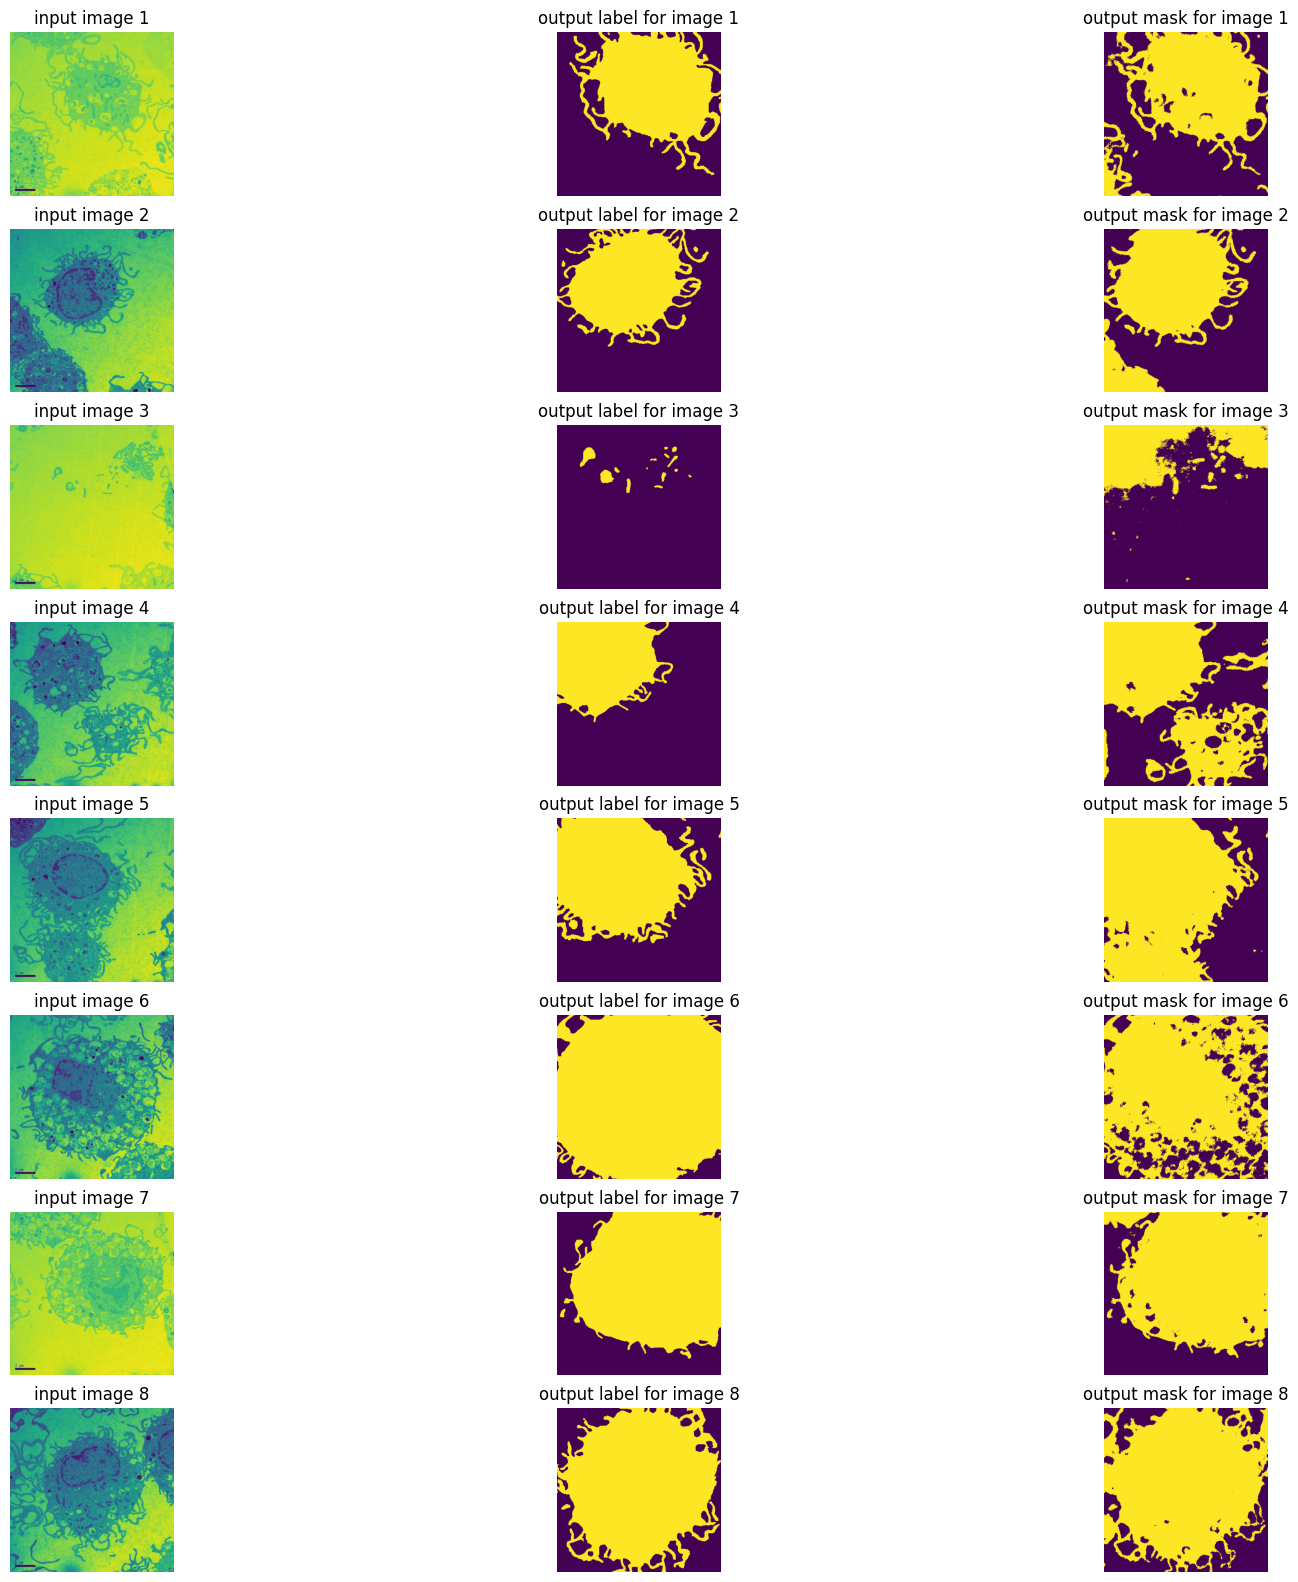

In [14]:
fig, axes = plt.subplots(testset.__len__(), 3, figsize = (20, 20))

for i in range(testset.__len__()):
  axes[i, 0].imshow(input[i])
  axes[i, 0].axis('off')
  axes[i, 0].set_title("input image {}".format(i + 1))

  axes[i, 1].imshow(output_labels[i])
  axes[i, 1].axis('off')
  axes[i, 1].set_title("output label for image {}".format(i + 1))

  axes[i, 2].imshow(output_masks[i])
  axes[i, 2].axis('off')
  axes[i, 2].set_title("output mask for image {}".format(i + 1))